In [54]:
import warnings
warnings.simplefilter(action='ignore')

In [55]:
import random
import numpy as np
import pandas as pd

In [56]:
from scipy.sparse import csr_matrix

In [57]:
from sklearn.neighbors import NearestNeighbors

In [58]:
df_music_instruments = pd.read_csv('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv', header=None)
df_music_instruments.columns = ['userId', 'productId', 'rating', 'timestamp']

In [93]:
df_music_instruments

,userId,productId,rating,timestamp
0,A1YS9MDZP93857,0006428320,3.0,1394496000
1,A3TS466QBAWB9D,0014072149,5.0,1370476800
2,A3BUDYITWUSIS7,0041291905,5.0,1381708800
3,A19K10Z0D2NTZK,0041913574,5.0,1285200000
4,A14X336IB4JD89,0201891859,1.0,1350432000
...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,5.0,1405641600
500172,A3PAQGM6P87MXO,B00LJD5AUM,5.0,1404518400
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,5.0,1404518400
500174,AIDHT6KXOL64T,SMLRBIMX03,5.0,1355788800


In [94]:
# 2. Create a simple recommender system that recommends the highest rated instruments

In [95]:
n_instruments = df_music_instruments.productId.unique().shape[0]
n_users = df_music_instruments.userId.unique().shape[0]
n_ratings = df_music_instruments.rating.shape[0]
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique instruments: {n_instruments}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_instruments, 2)}")

Number of ratings: 500176
Number of unique instruments: 83046
Number of unique users: 339231
Average ratings per user: 1.47
Average ratings per movie: 6.02


In [96]:
df_user_freq = df_music_instruments[['userId', 'productId']].groupby('userId').count().reset_index()
df_user_freq.columns = ['userId', 'n_ratings']
df_user_freq

,userId,n_ratings
0,A0002382258OFJJ2UYNTR,1
1,A000744229JN9C72EHIVF,1
2,A00097363JKNBC4UZRGPX,1
3,A00116463B7B37ZYMF04A,1
4,A001211614UB7M3DVLGSE,1
...,...,...
339226,AZZWPNME0GQZ2,2
339227,AZZX23UGJGKTT,4
339228,AZZXW4PH4OEEK,1
339229,AZZYI1EW1WY3M,1


In [97]:
df_mean_ratings = df_music_instruments.groupby('productId')[['rating']].mean()
df_mean_ratings

,rating
productId,
0006428320,3.0
0014072149,5.0
0041291905,5.0
0041913574,5.0
0201891859,1.0
...,...
B00LEWRD80,2.0
B00LIR7QNS,5.0
B00LJD5AUM,5.0


<AxesSubplot: >

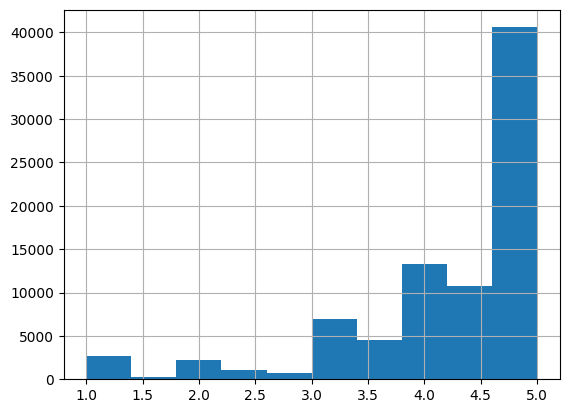

In [98]:
df_mean_ratings['rating'].hist()

In [99]:
df_lowest_rated = df_mean_ratings[df_mean_ratings['rating'] == df_music_instruments['rating'].min()]
df_lowest_rated = df_lowest_rated.merge(df_music_instruments, on='productId').reset_index(drop=True)
df_lowest_rated

,productId,rating_x,userId,rating_y,timestamp
0,0201891859,1.0,A14X336IB4JD89,1.0,1350432000
1,1423403363,1.0,A2G2DXPFZKG48W,1.0,1298160000
2,1423403363,1.0,A149OZDGI4VK7P,1.0,1360627200
3,157560860X,1.0,A36361OBBDOWDQ,1.0,1262908800
4,6305275432,1.0,A2ZISS0NCMT6FT,1.0,1318982400
...,...,...,...,...,...
3058,B00KFEZOA2,1.0,A3980S0UCCG9CB,1.0,1405123200
3059,B00KLLKE04,1.0,A2J6EBTC11X0QR,1.0,1405123200
3060,B00KMFUCC4,1.0,A29UMYO56IEZ2E,1.0,1403395200
3061,B00KRAG53E,1.0,A1VC2JTW35ZMFP,1.0,1403049600


In [100]:
df_highest_rated = df_mean_ratings[df_mean_ratings['rating'] == df_music_instruments['rating'].max()]
df_highest_rated = df_highest_rated.merge(df_music_instruments, on='productId').reset_index(drop=True)
df_highest_rated

,productId,rating_x,userId,rating_y,timestamp
0,0014072149,5.0,A3TS466QBAWB9D,5.0,1370476800
1,0041291905,5.0,A3BUDYITWUSIS7,5.0,1381708800
2,0041913574,5.0,A19K10Z0D2NTZK,5.0,1285200000
3,0577088726,5.0,A2HR0IL3TC4CKL,5.0,1371168000
4,0634050028,5.0,A1BX81N79C9BVT,5.0,1369872000
...,...,...,...,...,...
54814,B00L75HFOQ,5.0,A1EITL4Y22NWC0,5.0,1405555200
54815,B00LBEUTN2,5.0,A2B36P2QL36J7U,5.0,1405123200
54816,B00LIR7QNS,5.0,A2XEVARMJP81E,5.0,1405641600
54817,B00LJD5AUM,5.0,A3PAQGM6P87MXO,5.0,1404518400


In [101]:
# 3. Create a collaborative filtering system that recommends similar instruments to the one given

In [102]:
N = len(df_music_instruments['userId'].unique())
M = len(df_music_instruments['productId'].unique())
print(f"Number of users: {N}")
print(f"Number of instruments: {M}")

Number of users: 339231
Number of instruments: 83046


In [103]:
user_mapper = dict(zip(np.unique(df_music_instruments["userId"]), list(range(N))))
instruments_mapper = dict(zip(np.unique(df_music_instruments["productId"]), list(range(M))))
user_mapper

{'A0002382258OFJJ2UYNTR': 0,
 'A000744229JN9C72EHIVF': 1,
 'A00097363JKNBC4UZRGPX': 2,
 'A00116463B7B37ZYMF04A': 3,
 'A001211614UB7M3DVLGSE': 4,
 'A00166643JDONYF4HV38R': 5,
 'A00193422IMFQSHO9557H': 6,
 'A002211213O7OZD4NB6T4': 7,
 'A00250322GZSVDCQ44DBA': 8,
 'A00284702WL8BQHSOK67D': 9,
 'A0028518312V9G9GA1SDL': 10,
 'A0031542143934HC9VNXB': 11,
 'A0032366351NBY5321P69': 12,
 'A00338543M2OZPUWO9ZRU': 13,
 'A004176027NXFTHNBG3MW': 14,
 'A0047322388NOTO4N8SKD': 15,
 'A00492902HSM8TH90VHIT': 16,
 'A005127032XQB6G77QFAM': 17,
 'A005711235SC3Y7BR681Q': 18,
 'A00585421FNCF6DDYRIE9': 19,
 'A00593903MCE5GXTAGGNL': 20,
 'A00602363Q6SMEXZ7XCV4': 21,
 'A00616742NBLCNOXH3IKE': 22,
 'A00624361JQ09OIK9ETKL': 23,
 'A00625243BI8W1SSZNLMD': 24,
 'A006591110HYB1V32WX5C': 25,
 'A00673971SSQ4S7W7MSSG': 26,
 'A007093936II192M9KF38': 27,
 'A00709991QIAP5LOO93WA': 28,
 'A00766851QZZUBOVF4JFT': 29,
 'A00778832TW1B5CZXHRD2': 30,
 'A00782011FNUYCXRBZEM9': 31,
 'A0081289HG0BXFQJQUWW': 32,
 'A00824371061Q7KBYP8

In [104]:
instruments_mapper

{'0006428320': 0,
 '0014072149': 1,
 '0041291905': 2,
 '0041913574': 3,
 '0201891859': 4,
 '0577088726': 5,
 '0634029231': 6,
 '0634029347': 7,
 '0634029355': 8,
 '0634029363': 9,
 '0634050028': 10,
 '0634055429': 11,
 '0634055534': 12,
 '0634061801': 13,
 '0634065459': 14,
 '0739003755': 15,
 '0739037986': 16,
 '0739040251': 17,
 '0739040308': 18,
 '0739040375': 19,
 '0739042726': 20,
 '0739045032': 21,
 '0739045067': 22,
 '0739046500': 23,
 '0739048287': 24,
 '073904852X': 25,
 '0739051210': 26,
 '0739055224': 27,
 '0739056247': 28,
 '0739057561': 29,
 '0739059068': 30,
 '0739059114': 31,
 '0739060287': 32,
 '0739064525': 33,
 '0739069713': 34,
 '0739075934': 35,
 '0739076744': 36,
 '0739079883': 37,
 '0756028566': 38,
 '0757931847': 39,
 '0757990894': 40,
 '0767851013': 41,
 '0786615303': 42,
 '0849428866': 43,
 '0849706807': 44,
 '0849707692': 45,
 '0849734339': 46,
 '0849756677': 47,
 '0849757487': 48,
 '0881881037': 49,
 '0930948246': 50,
 '0975681753': 51,
 '0976054809': 52,
 '0

In [108]:
user_index = [user_mapper[i] for i in df_music_instruments['userId']]
instrument_index = [instruments_mapper[i] for i in df_music_instruments['productId']]
X = csr_matrix((df_music_instruments["rating"], (instrument_index, user_index)), shape=(M, N))
df_X = pd.DataFrame(X.toarray())
df_X

MemoryError: Unable to allocate 210. GiB for an array with shape (83046, 339231) and data type float64

In [ ]:
product_id = random.randint(0, n_instruments)
res = df_music_instruments.loc[df_music_instruments['productId'] == df_music_instruments['productId'].unique()[product_id]]
res

In [ ]:
res = str(res.productId.values[0])
res

In [ ]:
def find_similar_instruments(movie_id, X, k):
    neighbour_ids = []
    product_idx = instruments_mapper[res]
    product_vec = X[product_idx]
    k=10
    knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric="cosine")
    knn.fit(X)
    product_vec = product_vec.reshape(1, -1)
    neighbour = knn.kneighbors(product_vec, return_distance=False)

    product_inv_mapper = dict(zip(list(range(M)), np.unique(df_music_instruments['productId'])))

    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(product_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
product_id = 'B00134MTQ0'
similar_ids = find_similar_instruments(product_id, X, k=10)
print(similar_ids)

In [ ]:
rated = df_music_instruments.loc[df_music_instruments['productId'] == product_id]
rated

In [89]:
user_index = [user_mapper[i] for i in df_music_instruments['userId']]
instrument_index = [instruments_mapper[i] for i in df_music_instruments['productId']]
X = csr_matrix((df_music_instruments["rating"], (instrument_index, user_index)), shape=(M, N))
df_X = pd.DataFrame(X.toarray())

df_X_T = df_X.T.copy()
df_X_T['userBias'] = df_X_T[df_X_T!=0].mean(numeric_only=True, axis=1)
df_X_T

MemoryError: Unable to allocate 210. GiB for an array with shape (83046, 339231) and data type float64

In [88]:
usrBias = df_X_T.iloc[rated["userId"].values]["userBias"]
usrBias = usrBias.reset_index(drop=True)
usrBias

NameError: name 'df_X_T' is not defined

In [90]:
df_rated = rated.reset_index(drop=True)
df_rated

,userId,productId,rating,timestamp
0,A1A05QGI4TU03P,B00134MTQ0,5.0,1297728000
1,A17YP2PBM5UZIE,B00134MTQ0,5.0,1234396800
2,A11XKY4EIU2KNR,B00134MTQ0,5.0,1209427200
3,A10EMAECWBNUD7,B00134MTQ0,5.0,1206057600
4,A1B3M5F5W3S7EP,B00134MTQ0,5.0,1271894400
5,A3361KTY53AP68,B00134MTQ0,4.0,1333584000
6,A2TITUUC6WRT07,B00134MTQ0,4.0,1257465600


In [91]:
filtering = df_rated["rating"]>=usrBias
filtering

NameError: name 'usrBias' is not defined

In [92]:
recommend = df_rated.loc[filtering]

print(recommend)

NameError: name 'filtering' is not defined